# **Temporal Fusion Transformer (TFT)**


**Firstly, change the runtime types into GPU!**




**Install the tensorflow 2.9.0 version, SeqMetrics, and ai4water**



In [1]:
!pip install tensorflow==2.9.0

In [2]:
!pip install SeqMetrics
!pip install ai4Water

**Read the packages**

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from SeqMetrics import RegressionMetrics
from ai4water.utils.utils import dateandtime_now, jsonize
from matplotlib import pyplot as plt

SEP = os.sep

C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:19: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [4]:
from ai4water.functional import Model
from ai4water.models import TFT


**Set working directory**

In [5]:
import os, sys

In [6]:
prefix = f'MCDI_SAC_{dateandtime_now()}'
PREFIX = f"MCDI_SAC_{dateandtime_now()}"

ITER = 0
num_iterations = 20
seed=None
SEEDS = np.random.randint(0, 1000, num_iterations)
# to keep track of seed being used at every optimization iteration
SEEDS_USED = []
MONITOR = {"mse": [], "nse": [], "r2": [], "pbias": [], "nrmse": []}

**Load data (You should replace this with your data!)**

In [7]:
#df_a = pd.read_excel('Jeju_Train.xlsx', parse_dates=True)
df_a = pd.read_excel('Data/Jeju_Train.xlsx', parse_dates=True)

In [8]:
#df_b = pd.read_excel('Jeju_Test.xlsx', parse_dates=True)
df_b = pd.read_excel('Data/Jeju_Test.xlsx', parse_dates=True)

**Set the hyperparameters and make TFT model structure (You should replace this with your data!)**

In [9]:
# You should change!

output_size = 1  # number of classes
lookback = 4
lr = 0.001
num_inputs = 8
num_heads = 3
num_outputs = 1

In [10]:
# You should change!

params = {
    'total_time_steps': lookback,
    'num_encoder_steps': lookback,
    'num_inputs': num_inputs,
    'category_counts': [],
    'input_obs_loc': [],  # leave empty if not available
    'static_input_loc': [0,2,3], # if not static inputs, leave this empty
    'known_regular_inputs': [0,1,2,3,4,5,6,7,8],
    'known_categorical_inputs': [],  # leave empty if not applicable
    'hidden_units': 16,
    'dropout_rate': 0.05, #original: 0.05// 0.5
    'num_heads': num_heads,
    'use_cudnn': False,
    'future_inputs': False,
    'return_sequences': True,
}

In [11]:
layers = {
    "Input": {"config": {"shape": (params['total_time_steps'], params['num_inputs']), 'name': "Model_Inputs"}},
    "TemporalFusionTransformer": {"config": params},
    "lambda": {"config": tf.keras.layers.Lambda(lambda _x: _x[Ellipsis, -1, :])},
    "Dense_out": {"config": {"units": num_outputs, "activation": 'sigmoid'}}
}

In [12]:
print(tf.__version__)

2.9.0


In [13]:
# You can change the hyperparameters.

model = Model(model=TFT(input_shape=(params['total_time_steps'], params['num_inputs']),
                        hidden_units=16,
                        num_heads=num_heads,
                        dropout=0.1,
                        num_outputs=num_outputs,
                        use_cudnn=False,
                        mode="regression",
                        output_activation=None,
                        backend="tf",
                        ),
              prefix=PREFIX,
              ts_args={"lookback": lookback},
              epochs=30,
              x_transformation=None, #"minmax"
              y_transformation=None #{"method": "log", "replace_zeros": True, "treat_negatives": True},
              )
if seed is None:
    seed = SEEDS[ITER]
    SEEDS_USED.append(seed)

model.seed_everything(seed)


            building DL model for  
            regression problem using Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 4, 8)]       0           []                               
                                                                                                  
 tf.__operators__.getitem (Slic  (None, 4, 8)        0           ['Input[0][0]']                  
 ingOpLambda)                                                                                     
                                                                                                  
 tf.__operators__.getitem_1 (Sl  (None, 4, 1)        0           ['tf.__operators__.getitem[0][0]'
 icingOpLambda)                                                  ]                                
              

In [17]:
# Check the data shape.
df_a.shape

(118690, 9)

**Training**

In [18]:
from ai4water.preprocessing import DataSet

In [16]:
df_a.shape

(118690, 9)

In [19]:
train_index = np.arange(0, 94949)
val_index = np.arange(94952, 118687)

In [20]:
df_s = DataSet(data=df_a, indices = {'training': train_index, 'validation': val_index}, ts_args={'lookback':lookback})

In [21]:
tf.config.run_functions_eagerly(True)

***** Training *****
input_x shape:  (94949, 4, 8)
target shape:  (94949, 1)
***** Validation *****
input_x shape:  (23735, 4, 8)
target shape:  (23735, 1)
Epoch 1/30


C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2968/2968 [==============================] - 700s 236ms/step - loss: 808.9324 - val_loss: 120.7766
Epoch 2/30
2968/2968 [==============================] - 682s 230ms/step - loss: 125.6933 - val_loss: 112.9392
Epoch 3/30
2968/2968 [==============================] - 685s 231ms/step - loss: 122.0935 - val_loss: 115.0335
Epoch 4/30
2968/2968 [==============================] - 684s 230ms/step - loss: 118.7875 - val_loss: 134.7964
Epoch 5/30
2968/2968 [==============================] - 685s 231ms/step - loss: 116.9479 - val_loss: 135.2541
Epoch 6/30
2968/2968 [==============================] - 685s 231ms/step - loss: 114.3122 - val_loss: 161.0552
Epoch 7/30
2968/2968 [==============================] - 686s 231ms/step - loss: 112.4892 - val_loss: 151.7902
Epoch 8/30
2968/2968 [==============================] - 681s 229ms/step - loss: 110.0872 - val_loss: 156.6663
Epoch 9/30
2968/2968 [==============================] - 682s 230ms/step - loss: 109.1243 - val_loss: 140.9158
Epoch 10/30
2968/2968

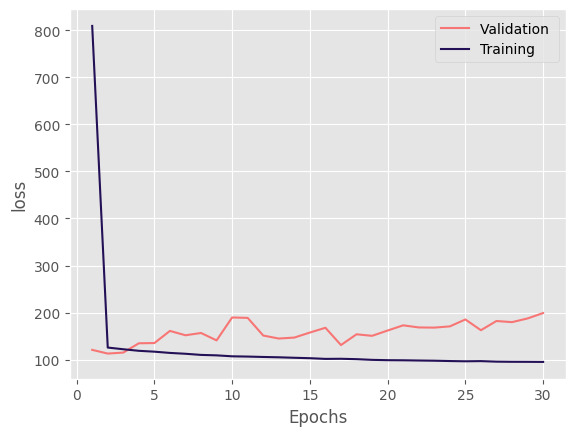

********** Successfully loaded weights from weights_002_112.93922.hdf5 file **********


In [22]:
model.fit(data=df_s)

**Prediction and check the performance**

***** Training *****
input_x shape:  (66464, 4, 8)
target shape:  (66464, 1)
   1/2077 [..............................] - ETA: 4:36

C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


2077/2077 [==============================] - 212s 102ms/step


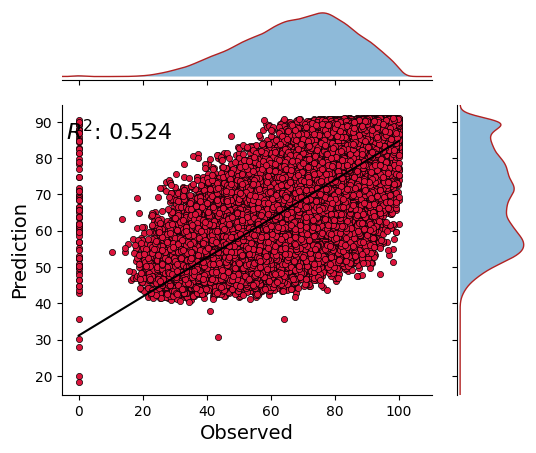

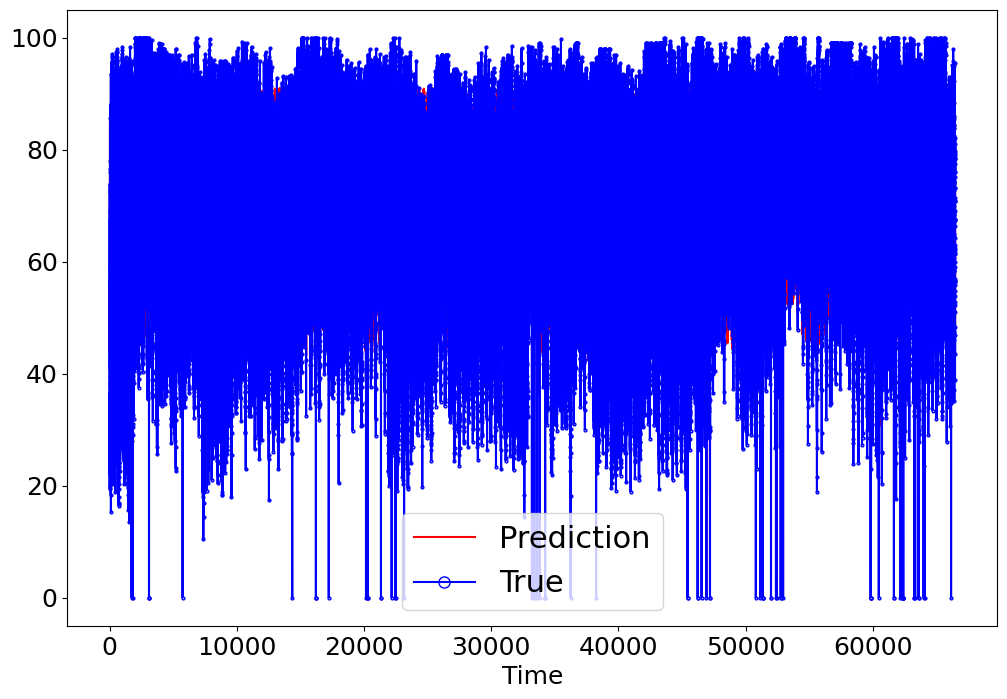

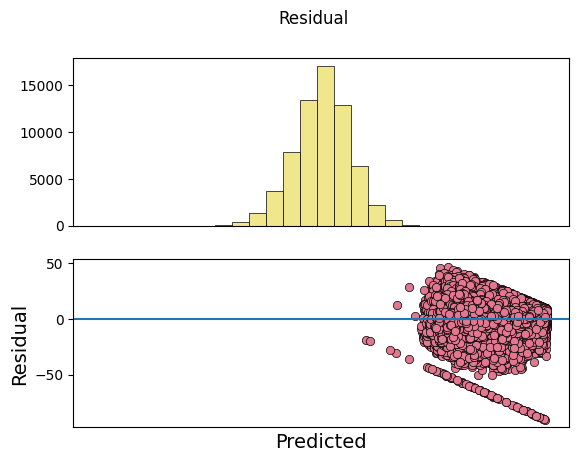

C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\SeqMetrics\_rgr.py:4264: RuntimeWarning: divide by zero encountered in log
  return np.log(true)
C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\SeqMetrics\_rgr.py:4256: RuntimeWarning: invalid value encountered in subtract
  clr_x = lx - m(lx)
C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\SeqMetrics\_rgr.py:6437: RuntimeWarning: divide by zero encountered in divide
  a = ((predicted - true) / true) ** 2


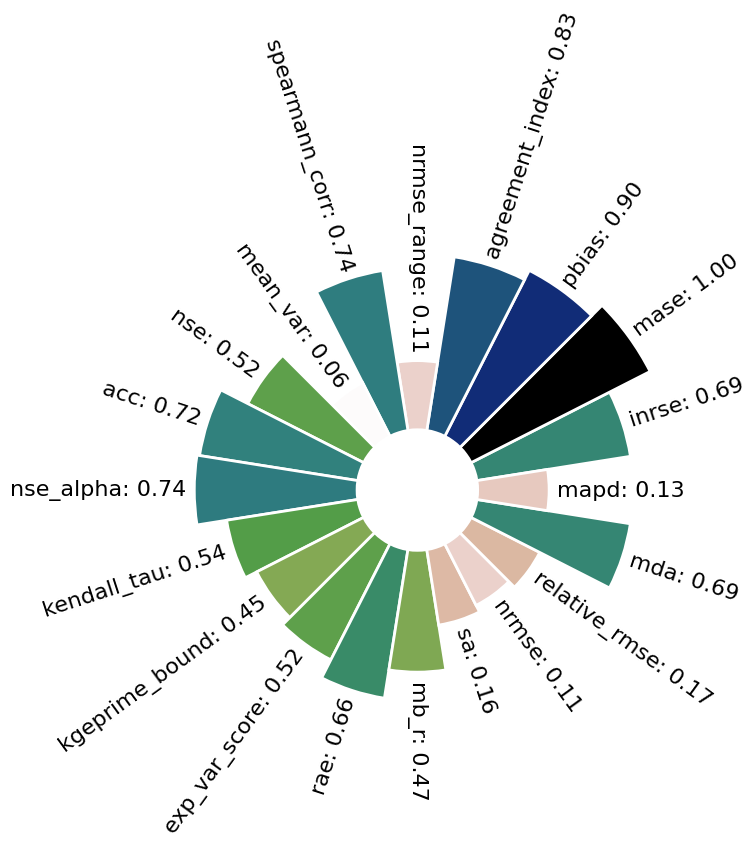

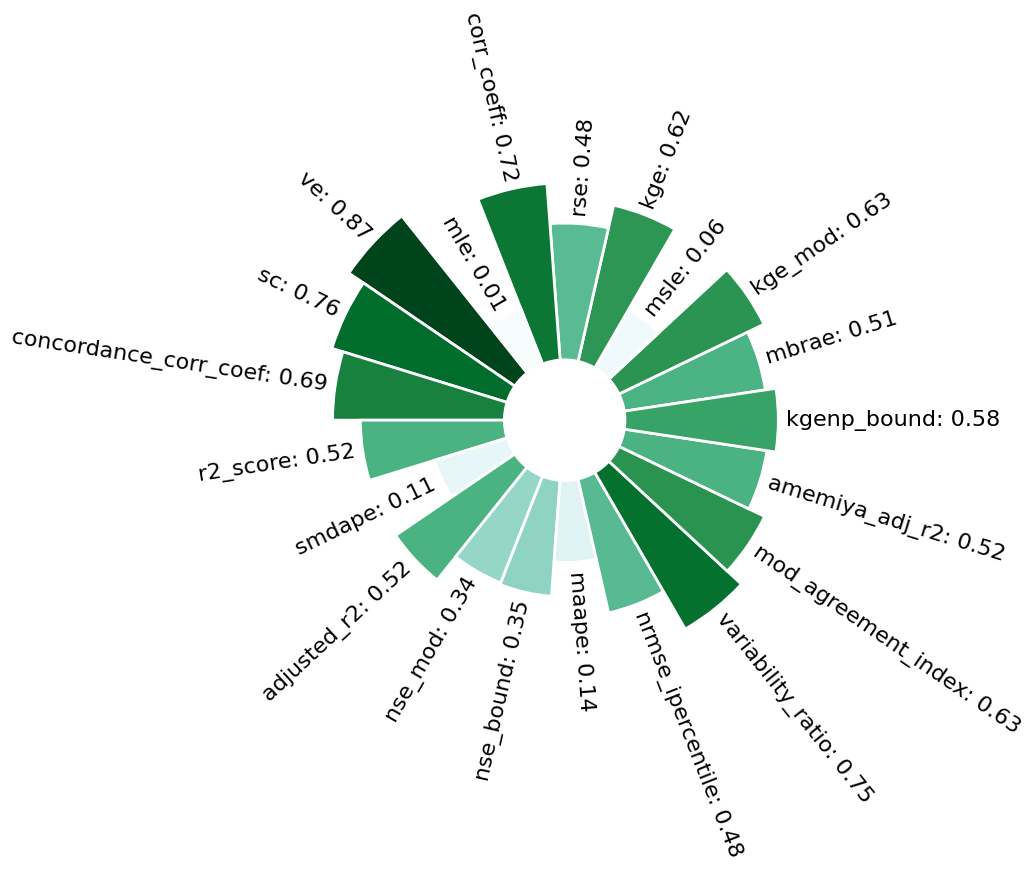

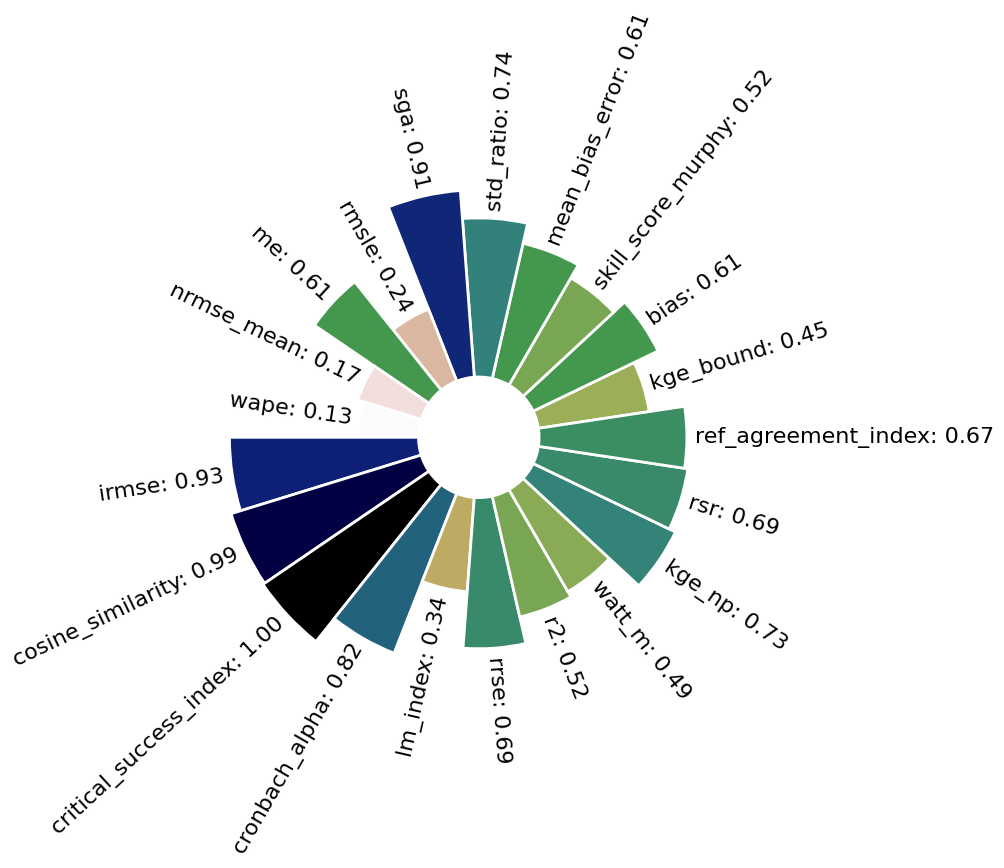

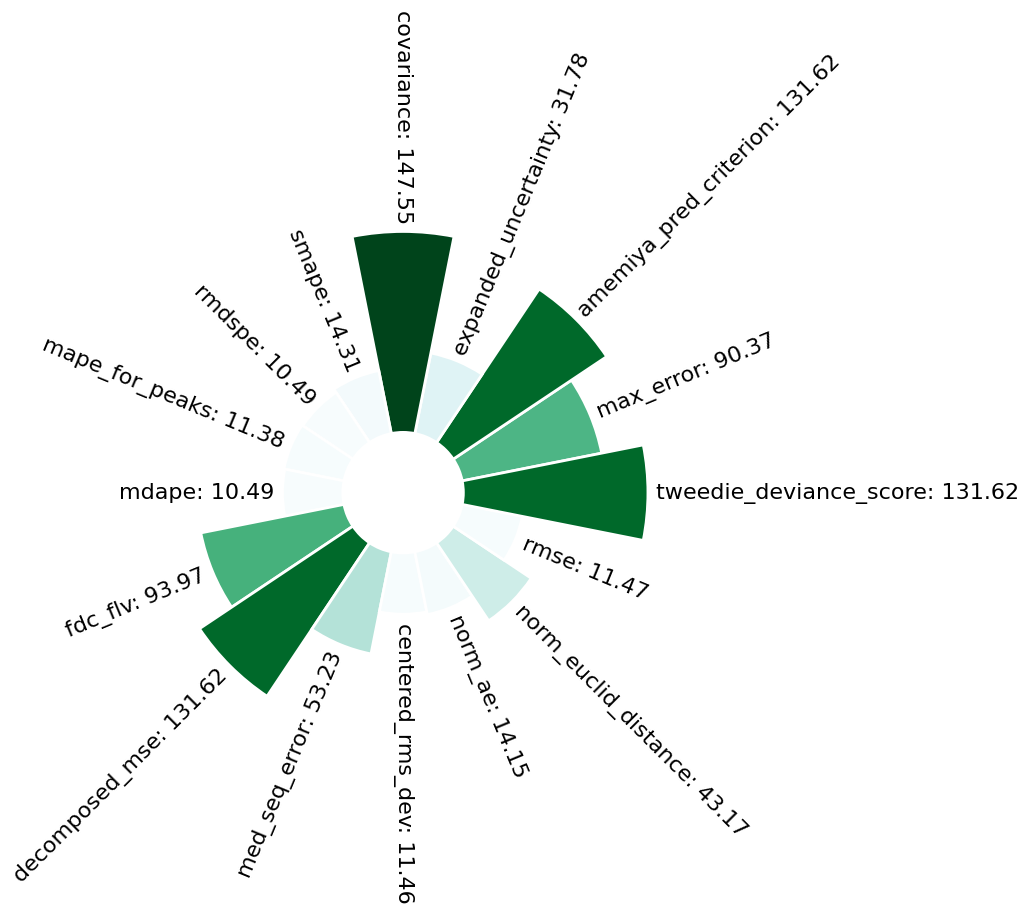

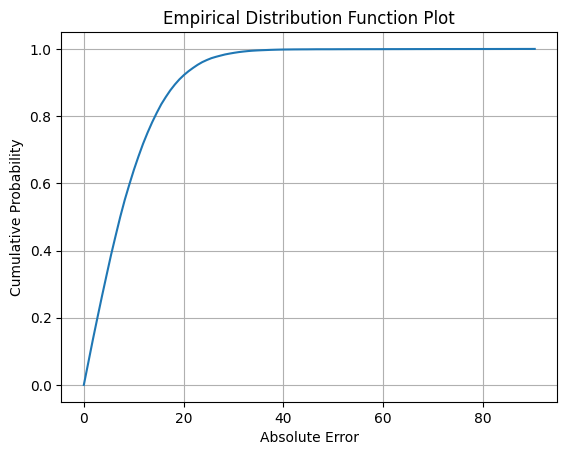

***** Validation *****
input_x shape:  (16616, 4, 8)
target shape:  (16616, 1)
  1/520 [..............................] - ETA: 53s

C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


520/520 [==============================] - 48s 93ms/step


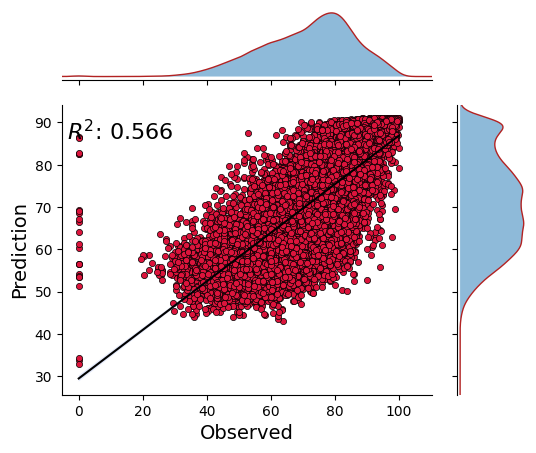

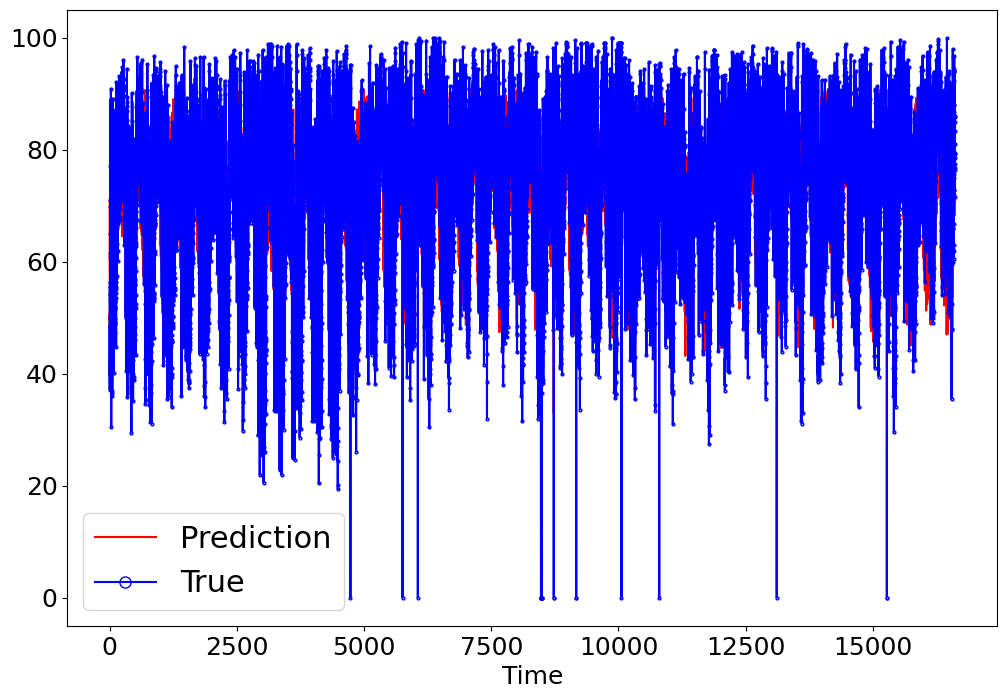

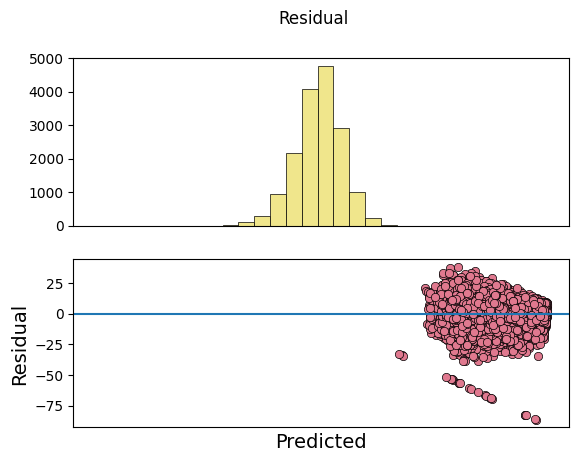

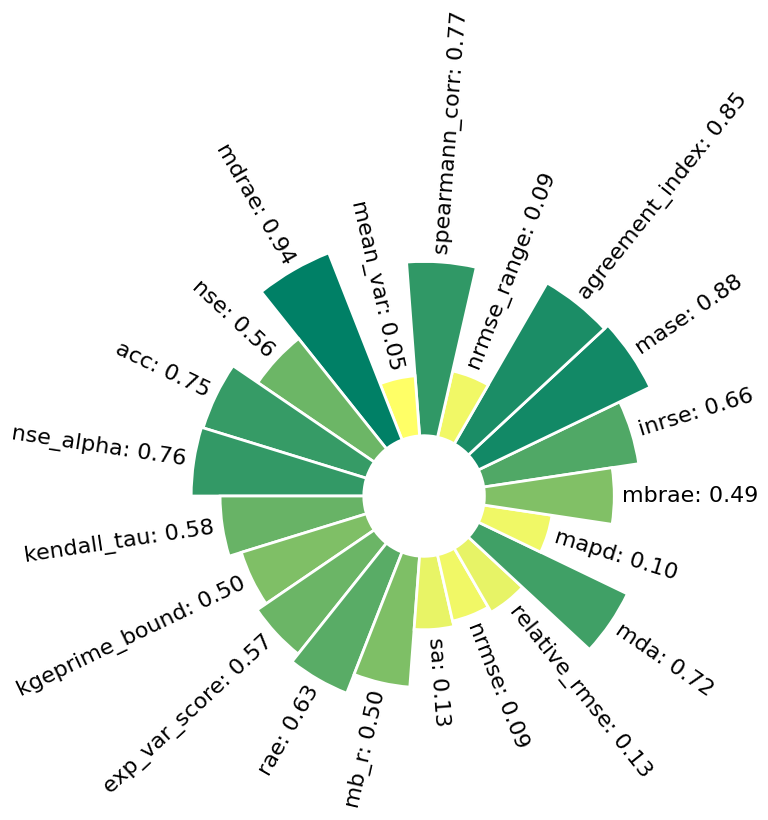

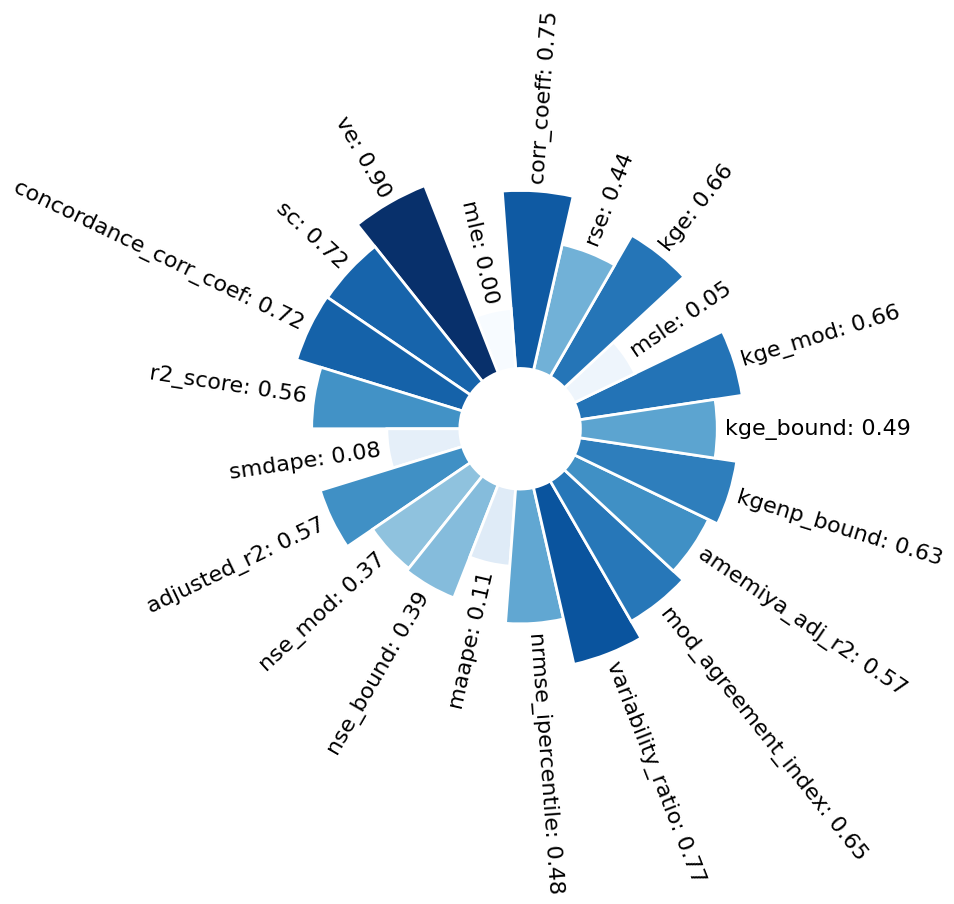

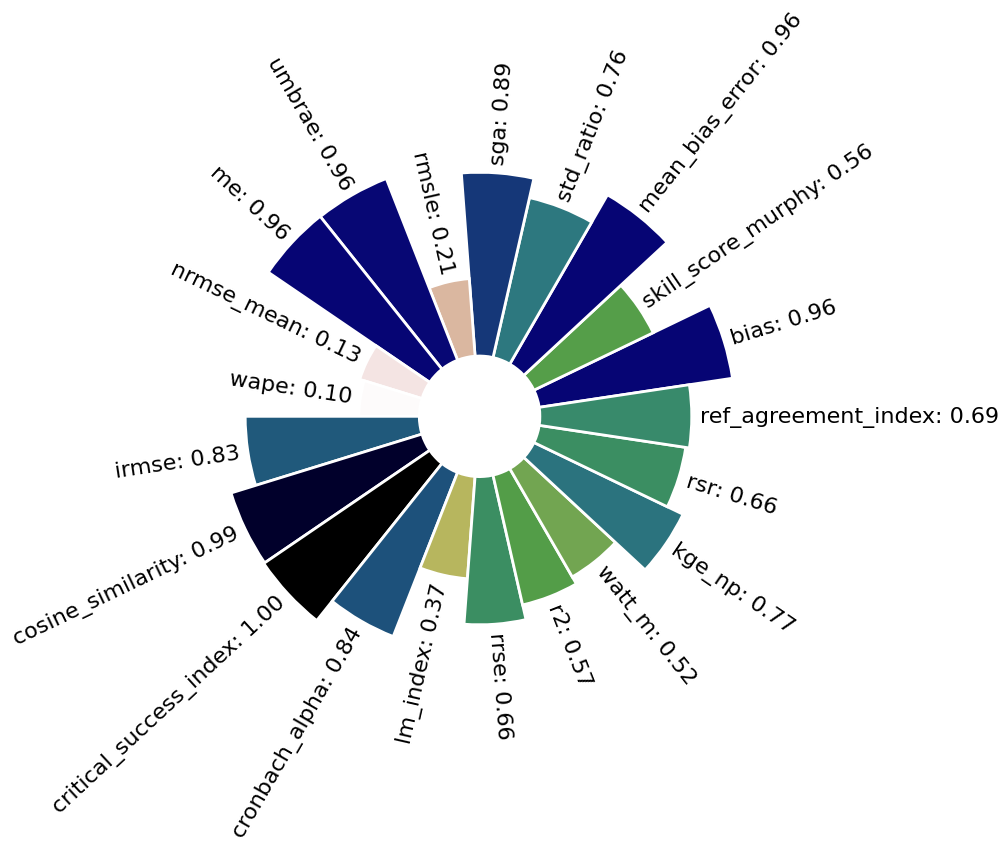

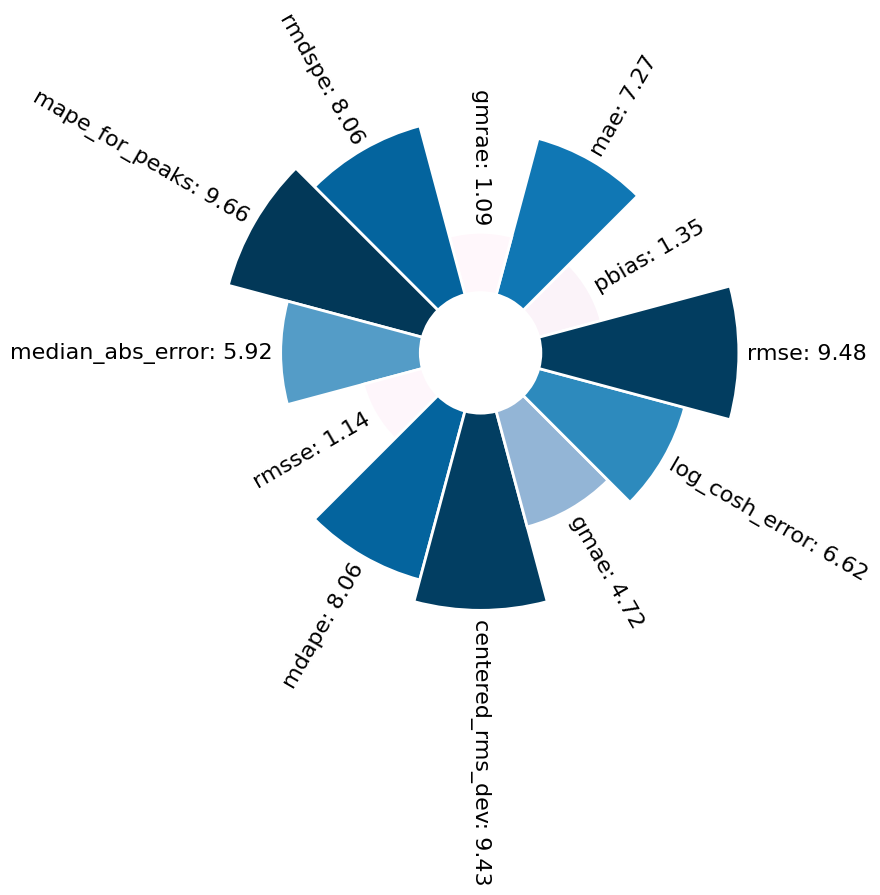

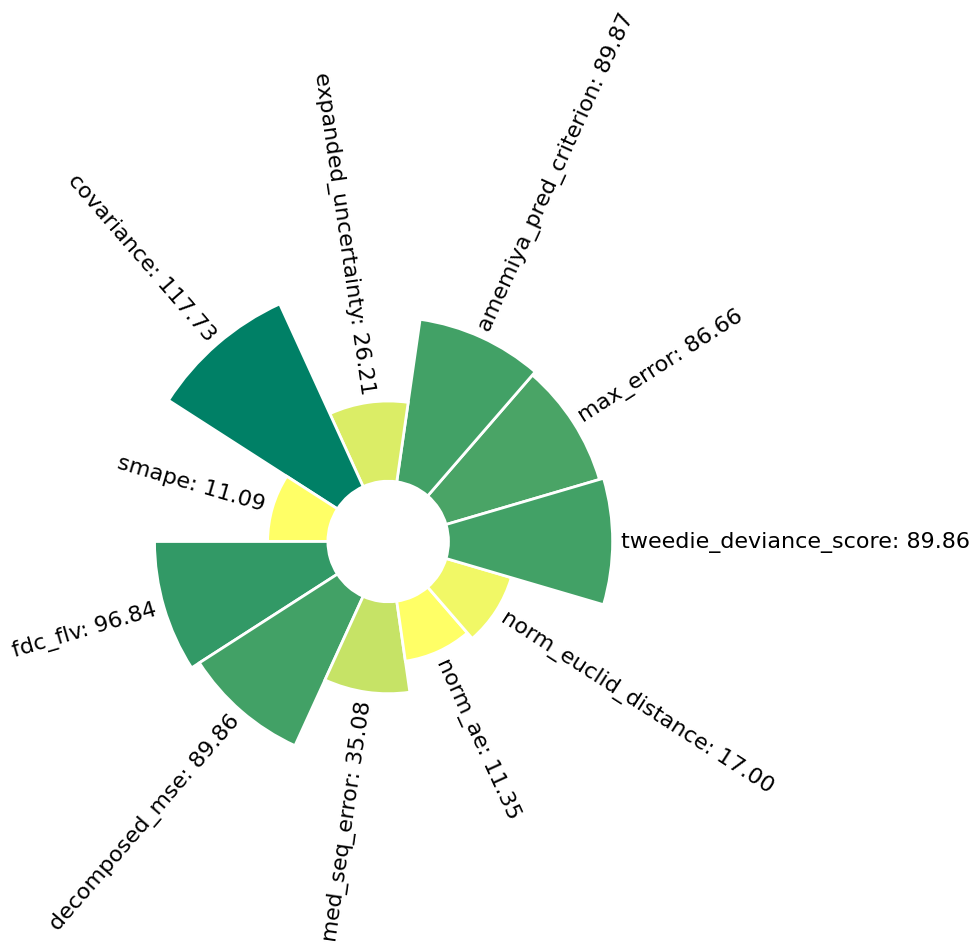

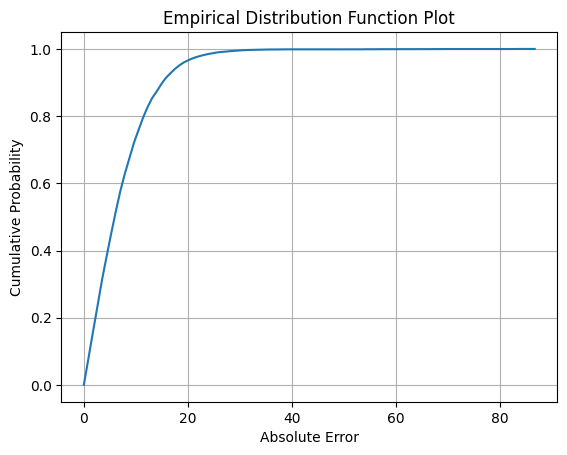

***** Training *****
input_x shape:  (1020, 4, 8)
target shape:  (1020, 1)
***** Validation *****
input_x shape:  (256, 4, 8)
target shape:  (256, 1)
***** Test *****
input_x shape:  (547, 4, 8)
target shape:  (547, 1)
 1/57 [..............................] - ETA: 5s

C:\Users\dongwoon\AppData\Local\anaconda3\envs\tft_env\lib\site-packages\tensorflow\python\data\ops\structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


57/57 [==============================] - 5s 93ms/step


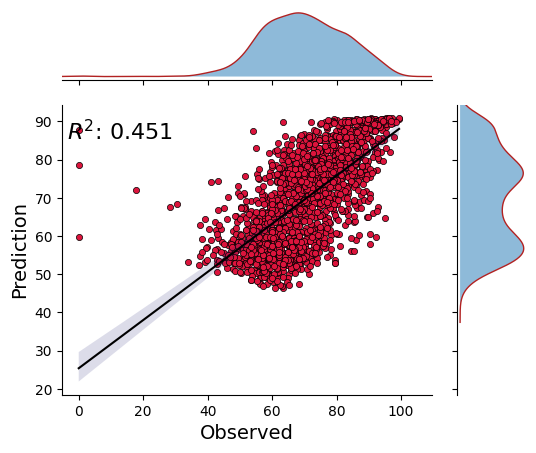

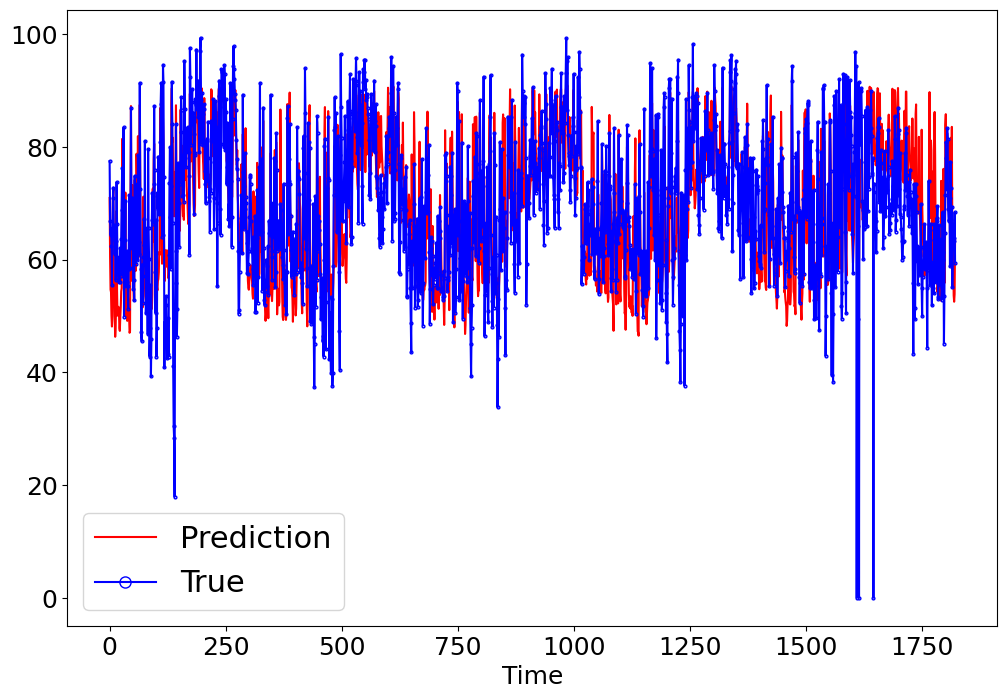

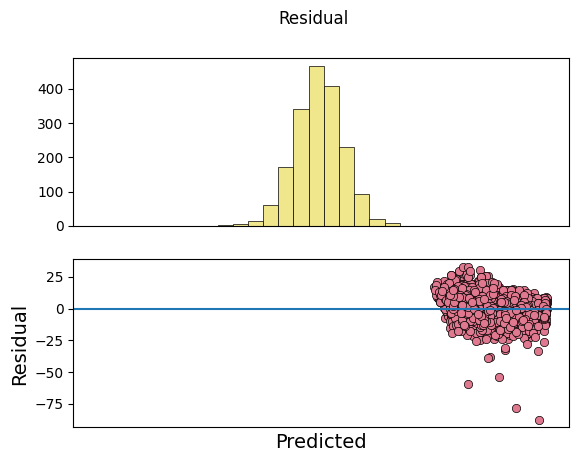

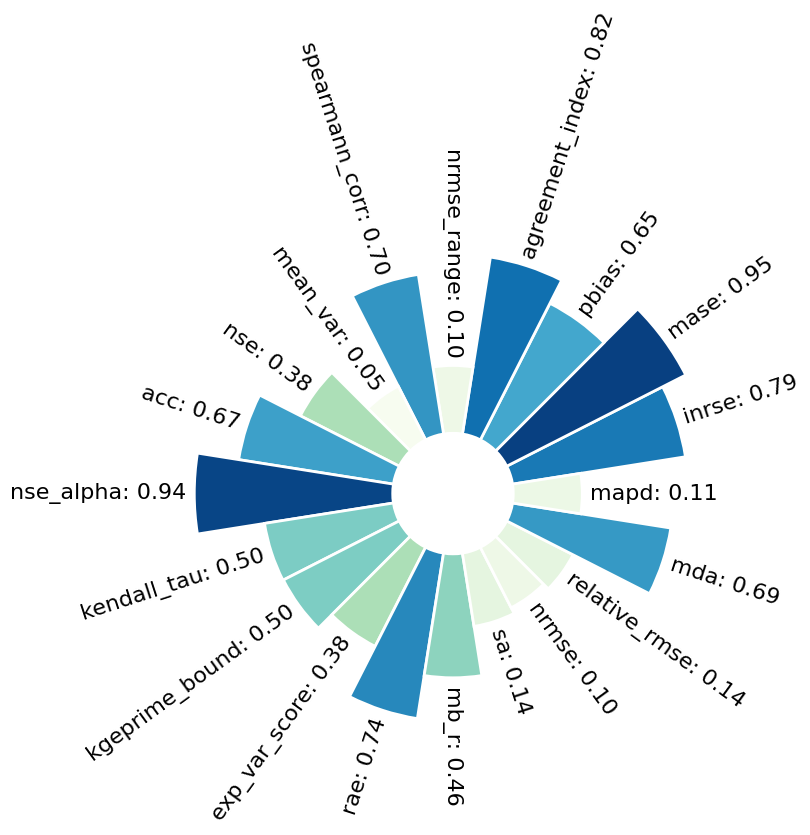

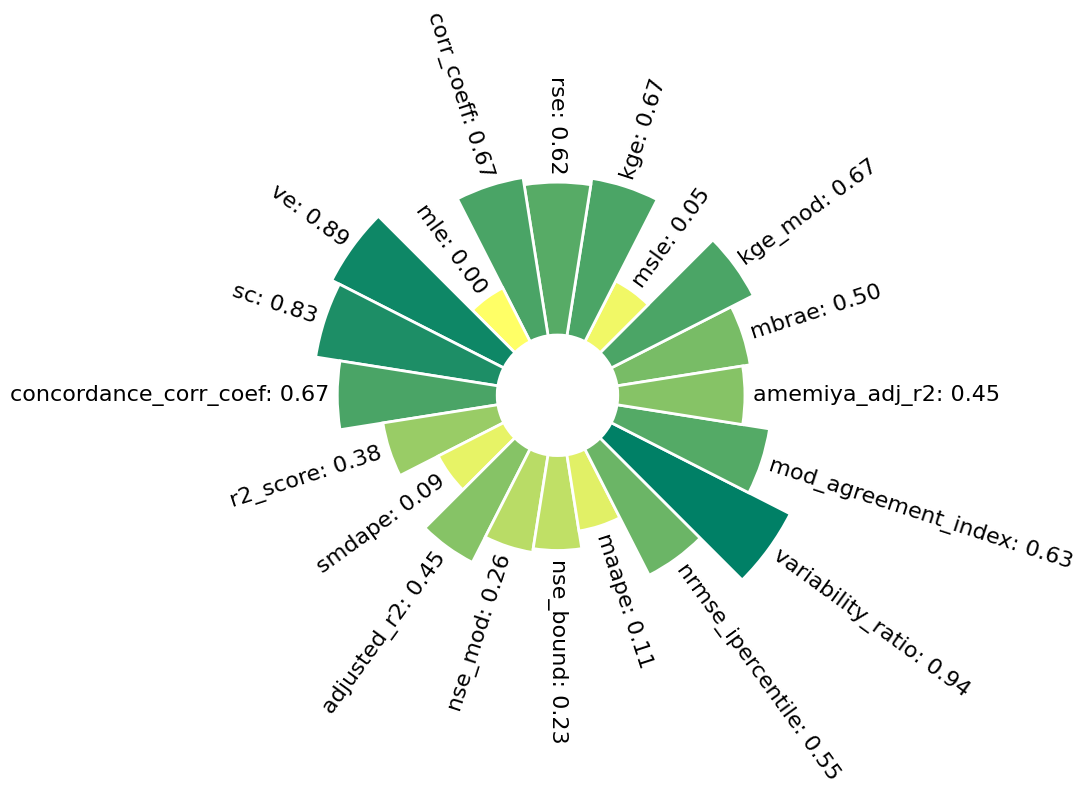

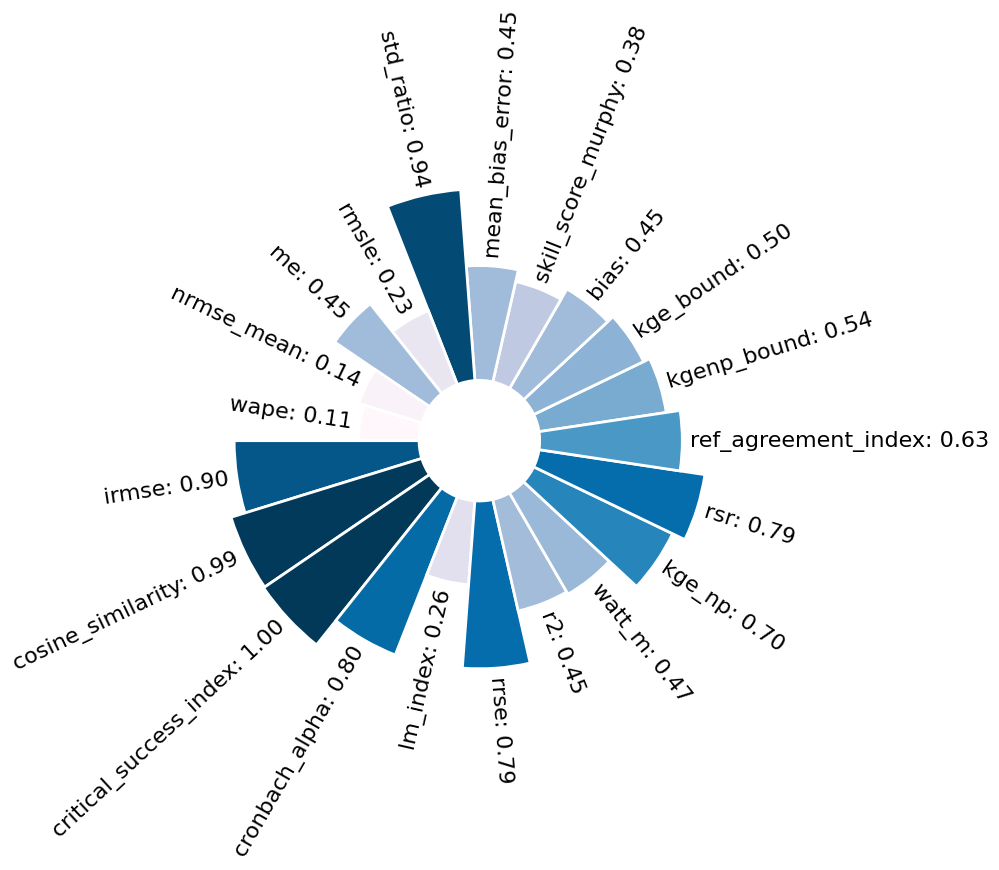

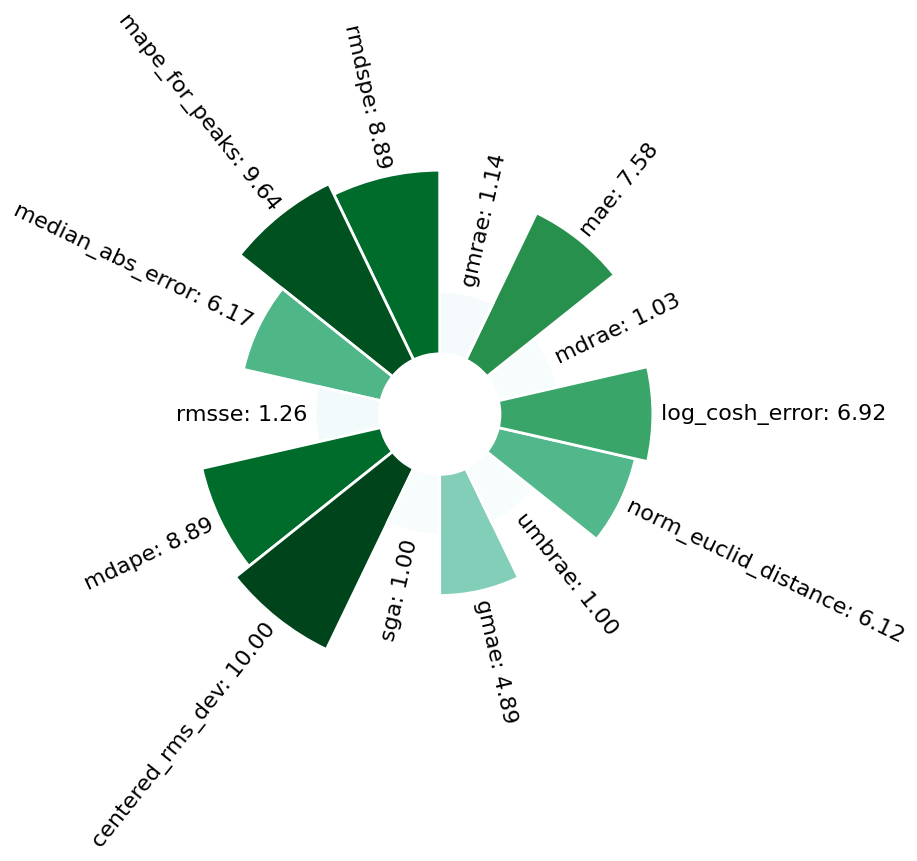

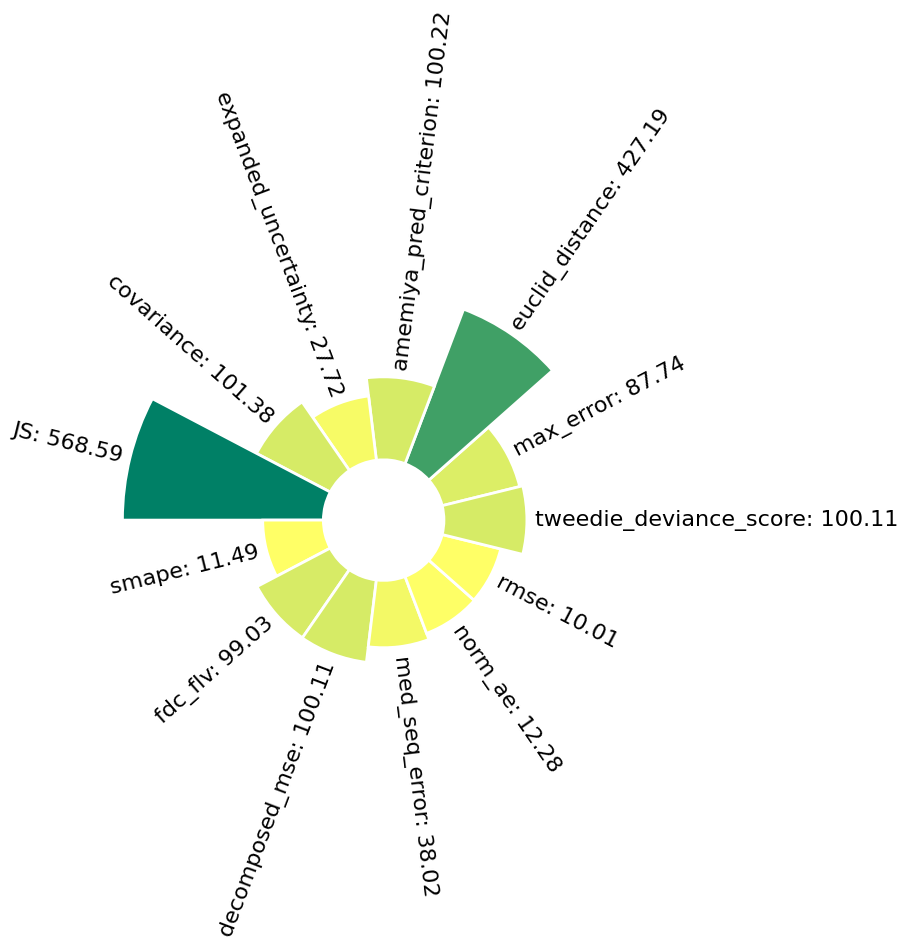

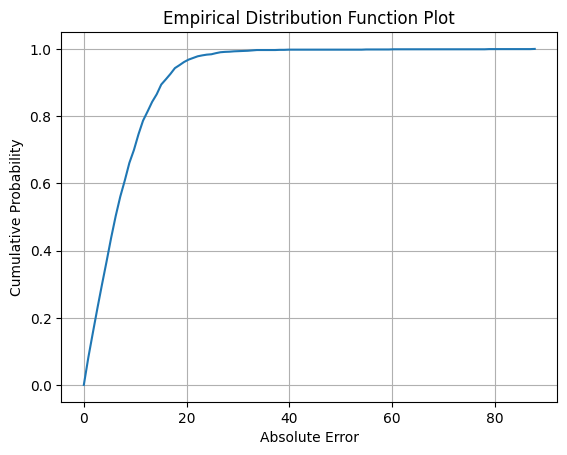

In [23]:
y_train, y_train_pred = model.predict_on_training_data(data=df_a, return_true=True)
y_valid, y_valid_pred = model.predict_on_validation_data(data=df_a, return_true=True)
y_test, y_test_pred = model.predict_on_all_data(data=df_b, return_true=True)